In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T

In [2]:
BATCH_SIZE = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.5,), (0.5,))
])

In [4]:
mnist = torchvision.datasets.MNIST(root='data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

In [5]:
dataloader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

In [6]:
images, labels = iter(dataloader).next()
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

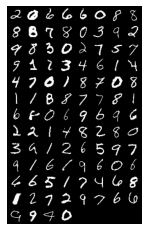

In [7]:
img = torchvision.utils.make_grid(images)
img = img.detach().numpy()
img = img.clip(0,1)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show();

In [8]:
LATENT_SIZE = 64
HIDDEN_SIZE = 256
IMAGE_SIZE = 784
EPOCHS = 100

In [9]:
D = nn.Sequential(
    nn.Linear(IMAGE_SIZE, HIDDEN_SIZE),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(HIDDEN_SIZE, 1),
    nn.Sigmoid())

In [10]:
G = nn.Sequential(
    nn.Linear(LATENT_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, IMAGE_SIZE),
    nn.Tanh())

In [11]:
D = D.to(device)
G = G.to(device)

In [12]:
bce_loss = nn.BCELoss()

d_optim = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optim = torch.optim.Adam(G.parameters(), lr=0.0002)

In [13]:
progress ={}
total_step = len(dataloader)
for epoch in range(1, EPOCHS + 1):
  for i, (images, _) in enumerate(dataloader):
    

    images = images.reshape(BATCH_SIZE, -1).to(device)
    real_labels = torch.ones(BATCH_SIZE, 1).to(device)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

    # Train the Discriminator
    outputs = D(images)
    d_loss_real = bce_loss(outputs, real_labels)
    real_score = outputs

    z = torch.randn(BATCH_SIZE, LATENT_SIZE).to(device)
    fake_images = G(z)

    outputs = D(fake_images)
    d_loss_fake = bce_loss(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake

    d_optim.zero_grad()
    g_optim.zero_grad()

    d_loss.backward()
    d_optim.step()

    # Train the Generator
    z = torch.randn(BATCH_SIZE, LATENT_SIZE).to(device)
    fake_images = G(z)

    outputs = D(fake_images)
    g_loss = bce_loss(outputs, real_labels) # Discriminator giving outputs as 1 for fake images is the optimization goal for Generator

    d_optim.zero_grad()
    g_optim.zero_grad()

    g_loss.backward()
    g_optim.step()

    if (i+1) % 200 == 0:
      print(f'Epoch: [{epoch}/{EPOCHS}] | Batch: [{i + 1}/{total_step}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | D(x): {real_score.mean().item():.2f} | D(G(z)): {fake_score.mean().item():.2f}')
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

  if epoch % 10 == 0:
    progress[epoch] = fake_images



Epoch: [1/100] | Batch: [200/600] | D Loss: 0.0954 | G Loss: 4.2912 | D(x): 0.98 | D(G(z)): 0.07
Epoch: [1/100] | Batch: [400/600] | D Loss: 0.4136 | G Loss: 4.0879 | D(x): 0.92 | D(G(z)): 0.19
Epoch: [1/100] | Batch: [600/600] | D Loss: 0.3451 | G Loss: 3.4896 | D(x): 0.89 | D(G(z)): 0.16
Epoch: [2/100] | Batch: [200/600] | D Loss: 0.1828 | G Loss: 4.0034 | D(x): 0.96 | D(G(z)): 0.10
Epoch: [2/100] | Batch: [400/600] | D Loss: 0.5360 | G Loss: 2.9052 | D(x): 0.82 | D(G(z)): 0.18
Epoch: [2/100] | Batch: [600/600] | D Loss: 0.4887 | G Loss: 3.1750 | D(x): 0.88 | D(G(z)): 0.21
Epoch: [3/100] | Batch: [200/600] | D Loss: 0.5452 | G Loss: 2.1736 | D(x): 0.82 | D(G(z)): 0.20
Epoch: [3/100] | Batch: [400/600] | D Loss: 1.0654 | G Loss: 1.3238 | D(x): 0.64 | D(G(z)): 0.33
Epoch: [3/100] | Batch: [600/600] | D Loss: 0.5049 | G Loss: 2.9967 | D(x): 0.85 | D(G(z)): 0.19
Epoch: [4/100] | Batch: [200/600] | D Loss: 0.2490 | G Loss: 3.5538 | D(x): 0.91 | D(G(z)): 0.09
Epoch: [4/100] | Batch: [400/6

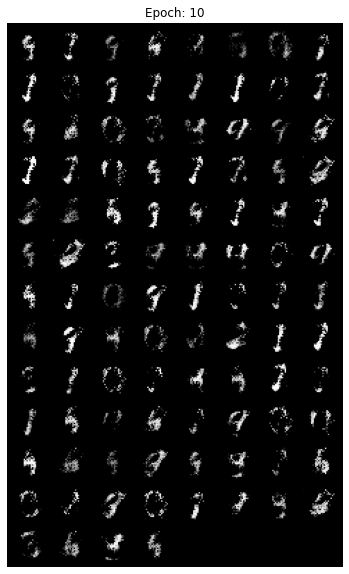

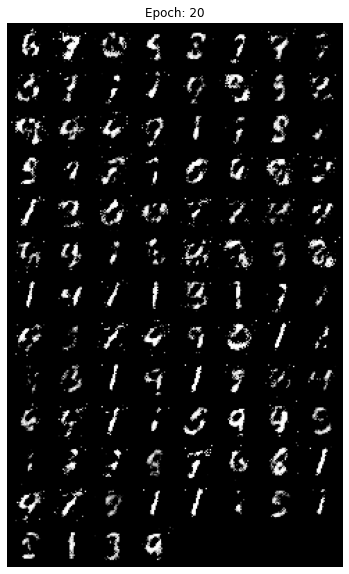

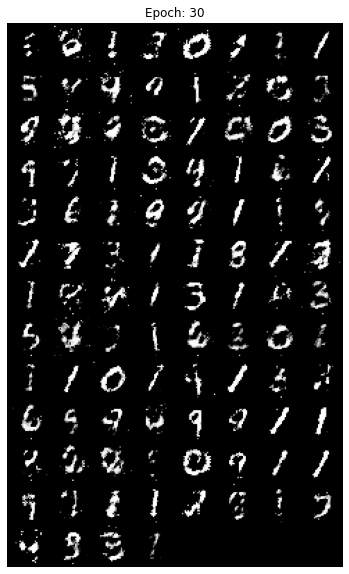

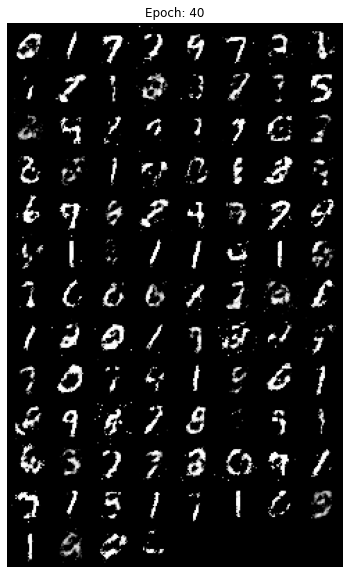

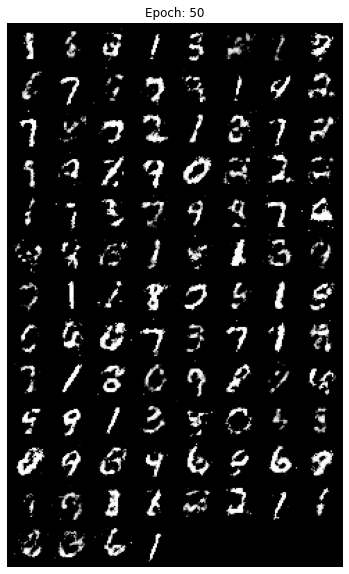

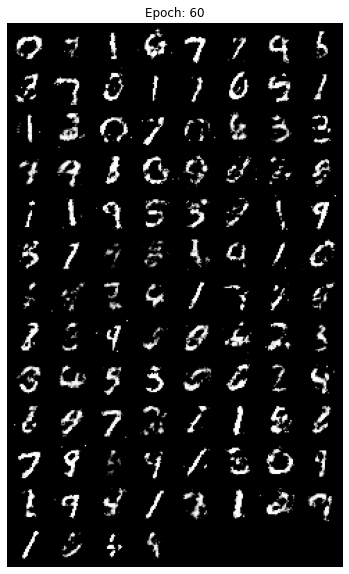

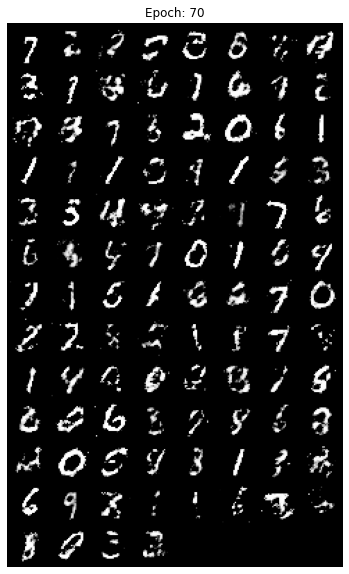

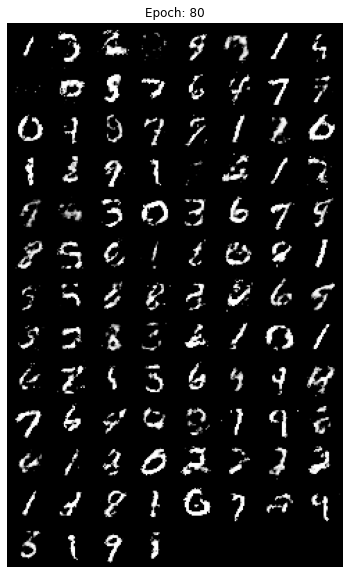

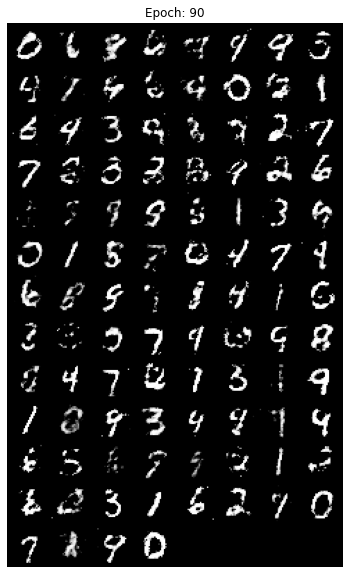

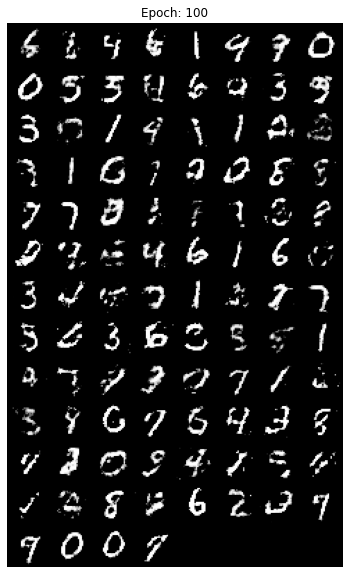

In [14]:
for epoch_num in progress:
  img = torchvision.utils.make_grid(progress[epoch_num])
  img = img.detach().cpu().numpy()
  img = img.clip(0, 1)
  plt.figure(figsize=(12,10))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(f'Epoch: {epoch_num}')
  plt.axis('off')
  plt.show();